# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 707.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB

We'll need an OpenAI API Key:

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [5]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [6]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 5c51551b


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [19]:
from google.colab import files
uploaded = files.upload()

Saving andrew-ng-machine-learning-yearning.pdf to andrew-ng-machine-learning-yearning.pdf


In [20]:
file_path = list(uploaded.keys())[0]
file_path

'andrew-ng-machine-learning-yearning.pdf'

We'll define our chunking strategy.

In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [22]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [23]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!



*   This only works when the text being embedded is exactly the same, perhaps with some minor normalization that does not affect meaning e.g. stripping out whitespaces and control characters. However even the same text that is semantically (and literally) almost the same would not result in a successful cache lookup unless some form of more significant normalization process was being applied – which would then to the question of whether the original text/query was being preserved properly in a reliable manner
*   There are security and privacy considerations (exacerbated given the huge delta) between the speed of results in the case of cache hits vs cache misses. One would easily be able to check if a particular query had been used against the chain/application/service before – positive knowledge of this could reveal or hint at private information another user did not intend to be revealed



##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [26]:
### YOUR CODE HERE
%%time
retriever.invoke("Should dev and test sets come from the same distribution?")

CPU times: user 44.3 ms, sys: 15.1 ms, total: 59.4 ms
Wall time: 475 ms


[Document(metadata={'source': 'source_135', 'file_path': 'andrew-ng-machine-learning-yearning.pdf', 'page': 70, 'total_pages': 118, 'format': 'PDF 1.4', 'title': 'andrew-ng-machine-learning-yearning', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.0 (Windows)', 'producer': 'Adobe PDF library 16.03', 'creationDate': "D:20220302111323+06'00'", 'modDate': "D:20220302111323+05'00'", 'trapped': '', '_id': 'e2143b7a2e9b4703a7d2839b83099e71', '_collection_name': 'pdf_to_parse_7e0ea6cc-d05c-4599-9e70-8e27cef89d22'}, page_content='from the same distribution. But I recommend against this method, because about \n205,000/210,000 ≈ 97.6% of your dev/test data would come from internet images, which \ndoes not reflect the actual distribution you want to do well on. Remember our \nrecommendation on choosing dev/test sets:  \nChoose dev and test sets to reflect data you expect to get in the future \nand want to do well on.  \nMost of the academic literature on machine lea

In [27]:
%%time
retriever.invoke("Should dev and test sets come from the same distribution?")

CPU times: user 39.6 ms, sys: 18.3 ms, total: 57.9 ms
Wall time: 318 ms


[Document(metadata={'source': 'source_135', 'file_path': 'andrew-ng-machine-learning-yearning.pdf', 'page': 70, 'total_pages': 118, 'format': 'PDF 1.4', 'title': 'andrew-ng-machine-learning-yearning', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.0 (Windows)', 'producer': 'Adobe PDF library 16.03', 'creationDate': "D:20220302111323+06'00'", 'modDate': "D:20220302111323+05'00'", 'trapped': '', '_id': 'e2143b7a2e9b4703a7d2839b83099e71', '_collection_name': 'pdf_to_parse_7e0ea6cc-d05c-4599-9e70-8e27cef89d22'}, page_content='from the same distribution. But I recommend against this method, because about \n205,000/210,000 ≈ 97.6% of your dev/test data would come from internet images, which \ndoes not reflect the actual distribution you want to do well on. Remember our \nrecommendation on choosing dev/test sets:  \nChoose dev and test sets to reflect data you expect to get in the future \nand want to do well on.  \nMost of the academic literature on machine lea

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [28]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [29]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [30]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

This only works for prompts that are exactly the same.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [31]:
%%time
chat_model.invoke("What are takeaways in setting up development and test sets?")

CPU times: user 135 ms, sys: 6.42 ms, total: 141 ms
Wall time: 8.33 s


AIMessage(content="Setting up development and test sets is crucial for building reliable machine learning models. Here are some key takeaways to consider:\n\n1. **Define Clear Objectives**:\n   - Understand the purpose of the development and test sets. The development set is typically used for tuning hyperparameters and making decisions about model configurations, while the test set is reserved for evaluating the final model's performance.\n\n2. **Proper Data Splitting**:\n   - Use techniques like random sampling, stratified sampling, or k-fold cross-validation to ensure that the development and test sets are representative of the overall dataset.\n   - Ensure that the data split prevents leakage, meaning that no information from the test set should influence the model training process.\n\n3. **Size Considerations**:\n   - The size of the development and test sets should be sufficient to provide reliable performance estimates. A common rule of thumb is to use 70%-80% of the data for tr

In [32]:
%%time
chat_model.invoke("What are takeaways in setting up development and test sets?")

CPU times: user 5.79 ms, sys: 0 ns, total: 5.79 ms
Wall time: 9.61 ms


AIMessage(content="Setting up development and test sets is crucial for building reliable machine learning models. Here are some key takeaways to consider:\n\n1. **Define Clear Objectives**:\n   - Understand the purpose of the development and test sets. The development set is typically used for tuning hyperparameters and making decisions about model configurations, while the test set is reserved for evaluating the final model's performance.\n\n2. **Proper Data Splitting**:\n   - Use techniques like random sampling, stratified sampling, or k-fold cross-validation to ensure that the development and test sets are representative of the overall dataset.\n   - Ensure that the data split prevents leakage, meaning that no information from the test set should influence the model training process.\n\n3. **Size Considerations**:\n   - The size of the development and test sets should be sufficient to provide reliable performance estimates. A common rule of thumb is to use 70%-80% of the data for tr

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [33]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [34]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Machine Learning Yearning."\n2. It is authored by Andrew Ng.\n3. The document is in PDF format, version 1.4.\n4. The total number of pages is 118.\n5. Page 4 discusses topics like directly learning rich outputs and error analysis.\n6. Page 5 mentions spotting flawed machine learning pipelines.\n7. The document uses a structured approach to discussing machine learning concepts.\n8. It emphasizes the importance of error analysis in model performance.\n9. The author suggests building a strong team for effective learning and collaboration.\n10. The document contains a section on optimization verification tests.\n11. It includes practical examples related to speech recognition systems.\n12. The document addresses the challenge of maximizing output in machine learning models.\n13. Beam search is introduced as an approximate search algorithm.\n14. The document provides insights into evaluating multiple ideas in parallel.\n15. It suggests using spr

In [35]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Machine Learning Yearning."\n2. It is authored by Andrew Ng.\n3. The document is in PDF format, version 1.4.\n4. The total number of pages is 118.\n5. Page 4 discusses topics like directly learning rich outputs and error analysis.\n6. Page 5 mentions spotting flawed machine learning pipelines.\n7. The document uses a structured approach to discussing machine learning concepts.\n8. It emphasizes the importance of error analysis in model performance.\n9. The author suggests building a strong team for effective learning and collaboration.\n10. The document contains a section on optimization verification tests.\n11. It includes practical examples related to speech recognition systems.\n12. The document addresses the challenge of maximizing output in machine learning models.\n13. Beam search is introduced as an approximate search algorithm.\n14. The document provides insights into evaluating multiple ideas in parallel.\n15. It suggests using spr

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

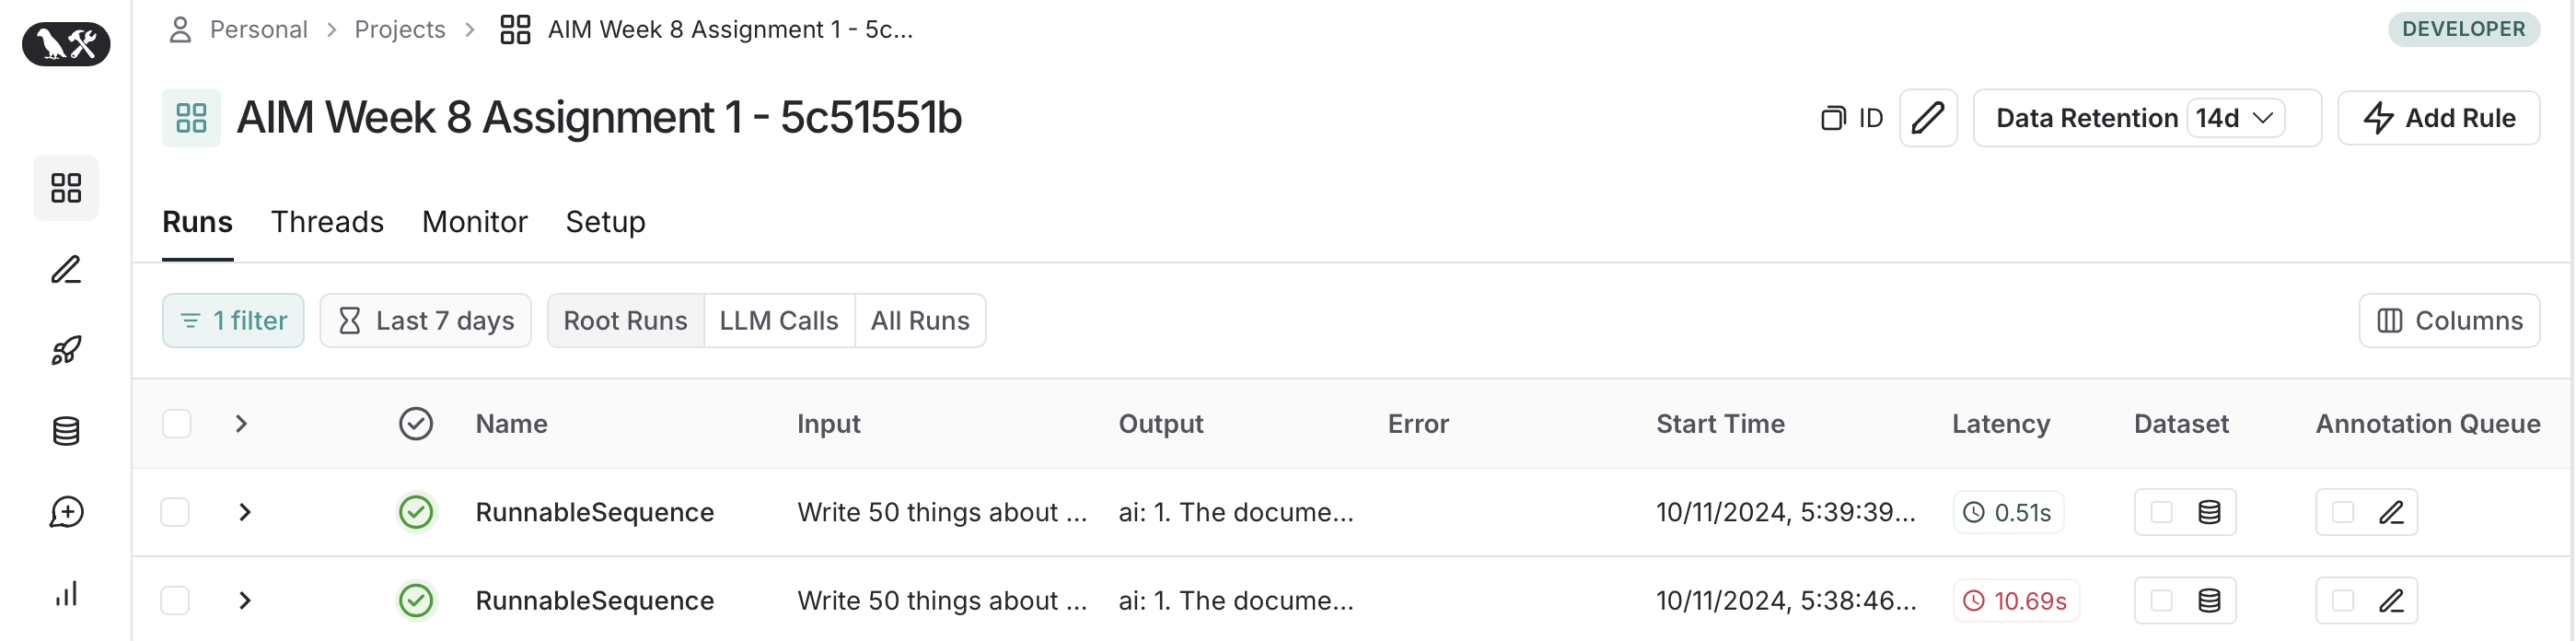